In [1]:
# automatically upload modules
%load_ext autoreload
%autoreload 2

In [23]:
from argparse import Namespace
import os
import pandas as pd
import pickle
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import torch

from genome_autoencoder import data_viz
from genome_autoencoder import evaluate
from genome_autoencoder import models
from genome_autoencoder import train_test
from genome_autoencoder import util

In [14]:
flags = Namespace(
    DATA_FP = '/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_autoencoder/data/', 
    SAVE_FP = '/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_autoencoder/',
    KEGG_FP = '/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/kegg_dataset/',
    data_source = 'kegg', #['get_homologues' | 'kegg']
    n_test = 0.1, # train-test split, n * 100 = % of data that goes into test set (e.g.: 0.1 -> 10%)
    num_epochs = 15, # IF CIRRICULUM, DO NOT SET < 3
    batch_size = 128,
    lr = 1e-3,
    print_every = 50, # print loss every n batches during training (5)
    replacement_threshold = 0.5, # probability over which binarizer converts to a 1
    num_corruptions = 100, # number of corrupted versions of a genome to produce
    corruption_fraction = 0.5, # fraction of genes to retain during corruption process
    phy_mode = "bacteria_only", # training with only bacteria vs also euk/arch
    cirriculum = True, # implement cirriculum learning based on gene count
    rare_threshold = 10 # drop features that occur fewer than this times in training ds 
    )

### Data exploration + preprocessing 

In [4]:
# First create genome representations (very slow)
# Each genome is a list of KO's and/or KEGG modules
if os.path.isfile(flags.DATA_FP+'genome_to_mod.csv'):
    print("Genome representations already exist")
else:
    genome_rep.genome_kos(flags.KEGG_FP)
    print("Must generate genome representations from scratch. This will take several hours.")

Genome representations already exist


In [5]:
df, cluster_names = util.load_data(flags.DATA_FP, flags.data_source)

In [6]:
# 'T04989': 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Pseudoalteromonadaceae;g__Pseudoalteromonas;s__Pseudoalteromonas_espejiana*
genome_to_tax = util.genome_to_tax(df)

In [ ]:
data_viz.tax_distrib(df, genome_to_tax)

In [ ]:
data_viz.module_stats(df)

In [ ]:
data_viz.genes_per_genome(df)

In [7]:
genome_to_tax2 = {}
for i in df.index:
    genome_to_tax2[i] = genome_to_tax[i]
    
# Create dict mapping each genome to a unique numerical ID
genome_to_num ={}
for i,genome in enumerate(df.index):
    genome_to_num[genome] = i
    
num_to_genome = {v: k for k, v in genome_to_num.items()}

In [8]:
# Split train-test sets in a phylogenetically balanced manner 
if os.path.isfile(flags.DATA_FP+'uncorrupted_train_balanced.csv'):
    print("Training-test split already exists, loading from file")
    train_orig = pd.read_csv(flags.DATA_FP+"uncorrupted_train_balanced.csv", index_col=0)    
    test_orig = pd.read_csv(flags.DATA_FP+"uncorrupted_test_balanced.csv", index_col=0)    
    
else:
    print("Generating train-test split")
    train_orig, test_orig = util.balanced_split(df, flags.n_test, genome_to_tax, 
                                                num_to_genome, flags.DATA_FP)    
    train_orig.to_csv(flags.DATA_FP+'uncorrupted_train_balanced.csv')
    test_orig.to_csv(flags.DATA_FP+'uncorrupted_test_balanced.csv')

Training-test split already exists, loading from file


In [9]:
# Remove rare features from train + test datasets
# Rare = fewer than n occurences in training dataset
# Last argument specifies n, set to correspond to 1% of genomes (3432 genomes -> n = 34)
train_orig, test_orig = util.remove_rare(train_orig, test_orig, df.shape[0]*0.01)

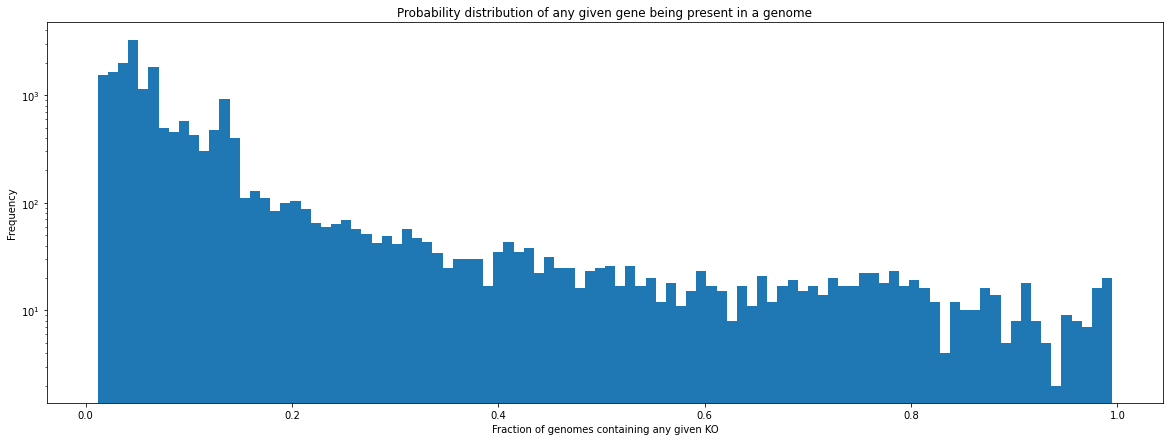

In [20]:
data_viz.hist_prob_ko(train_orig)

In [ ]:
# central carbon metabolism
ccm = ['M00001', 'M00002', 'M00003', 'M00307', 'M00009', 'M00010', 'M00011', 'M00004', 
       'M00006', 'M00007', 'M00580', 'M00005', 'M00008', 'M00308', 'M00633', 'M00309']
# sulfur metabolism
sm = ['M00176', 'M00596', 'M00595']
# photosynthesis 
ps = ['M00161', 'M00163', 'M00597', 'M00598']
# nitrogen metabolism
nm = ['M00175', 'M00531', 'M00530', 'M00529', 'M00528', 'M00804']

In [ ]:
df.shape[0]

In [ ]:
df[ccm].sum()/df.shape[0]*100

In [11]:
train_orig.shape

(3011, 18083)

In [12]:
train_genomes = train_orig.index.to_list()
test_genomes = test_orig.index.to_list()

In [15]:
# Produce corrupted genomes
# Could eventually do re-sampling / extra-corrupting to have more examples of "rare" genome types
#    e.g.: those from underrepresented groups M00003   

if os.path.isfile(flags.DATA_FP+'corrupted_train.pt'):
    print("Corrupted genomes already exist, loading from file")
    train_data = torch.load(flags.DATA_FP+"corrupted_train.pt")
    test_data = torch.load(flags.DATA_FP+"corrupted_test.pt")
    genome_idx_train = torch.load(flags.DATA_FP+"genome_idx_train.pt")
    genome_idx_test = torch.load(flags.DATA_FP+"genome_idx_test.pt")
else:
    print("Generating corrupted dataset from scratch with",flags.num_corruptions,"corruptions per genome")
    train_data, genome_idx_train = util.corrupt(train_orig, flags.num_corruptions, flags.corruption_fraction, 
                                                cluster_names, "train", flags.DATA_FP)

    test_data, genome_idx_test = util.corrupt(test_orig, flags.num_corruptions, flags.corruption_fraction, 
                                              cluster_names, "test", flags.DATA_FP)

Generating corrupted dataset from scratch


In [16]:
print(("There are %s genomes and %s features in the training dataset") % 
      (train_data.shape[0],int(train_data.shape[1]/2)))

print(("There are %s genomes and %s features in the test dataset") % 
      (test_data.shape[0],int(test_data.shape[1]/2)))

There are 301100 genomes and 18083 features in the training dataset
There are 42100 genomes and 18083 features in the test dataset


In [ ]:
if flags.phy_mode == "bacteria_only":
    train_data, train_tax_dict = util.bacteria_only(train_data, genome_idx_train, train_genomes, genome_to_tax)
    test_data, test_tax_dict = util.bacteria_only(test_data, genome_idx_test, test_genomes, genome_to_tax)

In [ ]:
train_data.shape, test_data.shape

In [ ]:
genome_to_tax['T06029']

In [ ]:
if flags.cirriculum:
    loaders = util.cirriculum_load(train_data, test_data, flags.batch_size, 
                           flags.batch_size, cluster_names)
else:
    loaders = util.dataloaders(train_data, test_data, flags.batch_size, 
                               flags.batch_size, cluster_names)

### Define and train network

In [ ]:
#num_features = train_data.dataset.shape[1]
num_features = train_data.shape[1] # Number of features in the entire dataset (train + test)

In [ ]:
# define the network
model = models.AutoEncoder(len(cluster_names))
print(model)

In [ ]:
# train the model
train_losses, test_losses, train_f1_scores, test_f1_scores = train_test.train_model(loaders, 
        model, flags.lr, flags.num_epochs, flags.print_every, flags.batch_size, 
        flags.SAVE_FP, flags.replacement_threshold, cluster_names, flags.cirriculum)

### Evaluate model performance

In [ ]:
# evaluate model performance
data_viz.learning_curve(train_f1_scores, test_f1_scores, "performance", flags.cirriculum)

In [ ]:
# evaluate model performance
data_viz.learning_curve(train_losses, test_losses, "optimization", flags.cirriculum)

In [ ]:
# create embeddings for test set
# first convert test_data from subset -> tensor, split corrupt vs target sets
tensor_test_data = torch.tensor([i.numpy() for i in test_data]).float()
corrupt_test_data = tensor_test_data[:,:len(cluster_names)]
#uncorrupt_test_data = tensor_test_data[:,len(cluster_names):]
#tensor_test_data = torch.tensor([i.numpy() for i in test_data]).float()
embeddings = train_test.generate_embeddings(model, corrupt_test_data)

In [ ]:
data_viz.plot_tSNE(embeddings, test_data, num_to_genome, genome_to_tax, test_tax_dict)

In [ ]:
# tSNE for corrupted genomes passed through untrained model
untrained_model = models.AutoEncoder(len(cluster_names))
untr_embeddings = train_test.generate_embeddings(untrained_model, corrupt_test_data)

In [ ]:
data_viz.plot_tSNE(untr_embeddings, test_data, num_to_genome, genome_to_tax, test_tax_dict)
# data_viz.plot_tSNE(untr_embeddings, test_data, num_to_genome, genome_to_tax, genome_idx_test)

In [ ]:
# Evaluate model and compare against baselines
# Get corrupted input set, target set, and predictions set (binarized to 1's and 0's)
#corrupt_test_data = tensor_test_data[:,:len(cluster_names)]
target = tensor_test_data[:,len(cluster_names):].detach().numpy()

model.eval()
with torch.no_grad():
    pred = model.forward(corrupt_test_data).detach().numpy()
b_pred = train_test.binarize(pred, flags.replacement_threshold)

In [ ]:
# Generate confusion matrix
evaluate.dom_confusion_matrix(b_pred, target, num_to_genome, genome_to_tax, test_tax_dict)

In [ ]:
# Baseline 1: untrained DAE
# Generate predictions using an untrained DAE model
model.eval()
with torch.no_grad():
    untr_pred = untrained_model.forward(corrupt_test_data).detach().numpy()
untr_b_preds = train_test.binarize(untr_pred, flags.replacement_threshold)

In [ ]:
if os.path.isfile(flags.DATA_FP+"rand_b_pred.pt"):
    print("Loading random predictions from file")
    rand_b_pred = torch.load(flags.DATA_FP+"rand_b_pred.pt")
else: 
    # This is slow
    print("Generating random predictions, this will take a while (~30 min)")
    rand_b_pred = evaluate.generate_baseline(num_features, train_data, 
                                             corrupt_test_data, "base_random", cluster_names)
    torch.save(rand_b_pred, flags.DATA_FP+"rand_b_pred.pt")

In [ ]:
if os.path.isfile(flags.DATA_FP+"smart_b_pred.pt"):
    print("Loading smart random predictions from file")
    smart_b_pred = torch.load(flags.DATA_FP+"smart_b_pred.pt")
else:
    print("Generating smart random predictions, this will take a while (~30 min)")
    smart_b_pred = evaluate.generate_baseline(num_features, train_data, 
                                          corrupt_test_data, "smart_random", cluster_names)
    torch.save(smart_b_pred, flags.DATA_FP+"smart_b_pred.pt")

In [ ]:
import pandas as pd
hs = evaluate.hamming(target, b_pred)
hs_stats = [round(sum(hs)/len(hs),2), round(min(hs),2), round(max(hs),2)]

untr_hs = evaluate.hamming(target, untr_b_preds)
untr_hs_stats = [round(sum(untr_hs)/len(untr_hs),2), round(min(untr_hs),2), round(max(untr_hs),2)]

rand_hs = evaluate.hamming(target, rand_b_pred)
rand_hs_stats = [round(sum(rand_hs)/len(rand_hs),2), round(min(rand_hs),2), round(max(rand_hs),2)]

smart_hs = evaluate.hamming(target, smart_b_pred)
smart_hs_stats = [round(sum(smart_hs)/len(smart_hs),2), round(min(smart_hs),2), round(max(smart_hs),2)]


hamming_df = pd.DataFrame([hs_stats, untr_hs_stats, rand_hs_stats, smart_hs_stats], columns=['mean', 'min', 'max'], 
                            index=["DAE trained", "DAE untrained", "Random chance", "Smart random chance"])
hamming_df

In [ ]:
hs[:5]